<a href="https://colab.research.google.com/github/davidgreenblott/TitanicSurvivalApacheSpark/blob/main/TitanicSurvival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .appName("TitanicSurvivalPrediction") \
        .getOrCreate()

In [3]:
!wget https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv

--2024-12-11 20:28:11--  https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  58.89K  --.-KB/s    in 0.01s   

2024-12-11 20:28:11 (4.50 MB/s) - ‘titanic.csv’ saved [60302/60302]



In [4]:
# Load the dataset
titanic_df = spark.read.csv("titanic.csv", header=True, inferSchema=True)

# View the data
titanic_df.show(5)


+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| NULL|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| NULL|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

In [10]:
titanic_df.show(15)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| NULL|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| NULL|       S|
|          6|       0|     3|    Moran, Mr. James|  male|NULL|    0|    0|      

In [11]:
from pyspark.sql.functions import when, col

# Fill missing values in Age and Embarked
titanic_df = titanic_df.fillna({"Age": 30, "Embarked": "S"})

# Create a new column for gender (0 for female, 1 for male)
titanic_df = titanic_df.withColumn("Gender", when(col("Sex") == "male", 1).otherwise(0))

# Select relevant columns
titanic_df = titanic_df.select("Survived", "Pclass", "Gender", "Age", "SibSp", "Parch", "Fare")

titanic_df.show(5)


+--------+------+------+----+-----+-----+-------+
|Survived|Pclass|Gender| Age|SibSp|Parch|   Fare|
+--------+------+------+----+-----+-----+-------+
|       0|     3|     1|22.0|    1|    0|   7.25|
|       1|     1|     0|38.0|    1|    0|71.2833|
|       1|     3|     0|26.0|    0|    0|  7.925|
|       1|     1|     0|35.0|    1|    0|   53.1|
|       0|     3|     1|35.0|    0|    0|   8.05|
+--------+------+------+----+-----+-----+-------+
only showing top 5 rows



In [13]:
from pyspark.ml.feature import VectorAssembler

# Define feature columns
feature_columns = ["Pclass", "Gender", "Age", "SibSp", "Parch", "Fare"]

# Initialize VectorAssembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform the DataFrame to include the 'features' column
titanic_transformed = assembler.transform(titanic_df)

# Display the first 5 rows with the 'features' column
titanic_transformed.select("features", "Survived").show(5)


+--------------------+--------+
|            features|Survived|
+--------------------+--------+
|[3.0,1.0,22.0,1.0...|       0|
|[1.0,0.0,38.0,1.0...|       1|
|[3.0,0.0,26.0,0.0...|       1|
|[1.0,0.0,35.0,1.0...|       1|
|[3.0,1.0,35.0,0.0...|       0|
+--------------------+--------+
only showing top 5 rows



In [14]:
# Split the data: 80% training and 20% testing
train_data, test_data = titanic_transformed.randomSplit([0.8, 0.2], seed=42)

print(f"Training Data Count: {train_data.count()}")
print(f"Test Data Count: {test_data.count()}")

Training Data Count: 746
Test Data Count: 145


In [15]:
from pyspark.ml.classification import LogisticRegression

# Initialize Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="Survived")

# Train the model on the training data
lr_model = lr.fit(train_data)

# Display model coefficients and intercept
print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)

Coefficients: [-1.1690736905099557,-2.6919721691808918,-0.041828510649450805,-0.3508197596437236,-0.15322168026948257,0.0020653603590849194]
Intercept: 5.186551981208289


In [16]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Initialize evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Survived")

# Calculate Area Under ROC (AUC)
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print(f"Test AUC: {auc:.4f}")

# Display a few prediction results
predictions.select("Survived", "prediction", "probability").show(5)

Test AUC: 0.8680
+--------+----------+--------------------+
|Survived|prediction|         probability|
+--------+----------+--------------------+
|       0|       1.0|[0.12074921023808...|
|       0|       1.0|[0.38852602086568...|
|       0|       1.0|[0.38102535093847...|
|       0|       1.0|[0.45650021909659...|
|       0|       1.0|[0.46866957206590...|
+--------+----------+--------------------+
only showing top 5 rows



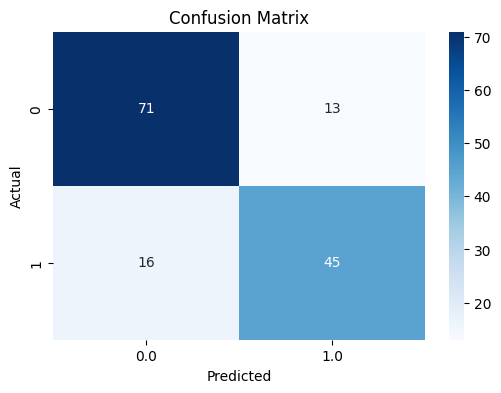

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert predictions to Pandas DataFrame
predictions_pd = predictions.select("Survived", "prediction").toPandas()

# Create a confusion matrix
confusion_matrix = pd.crosstab(predictions_pd['Survived'], predictions_pd['prediction'], rownames=['Actual'], colnames=['Predicted'])

# Plot the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
